In [1]:
import pandas as pd  
import os                
from datetime import datetime
import time
import matplotlib.pyplot as plt
from math import sin, cos, tan
import matplotlib.dates as mdates

#### check the data structure of all the files 

In [2]:

# loop through directory where your files are located
directory = './Data/'
dfs = []
i = 1
#loop through all the files in a data directory
for filename in os.listdir(directory):
    #ignore a file start with the name weekly, thats the mortageg rates data 
    if not filename.startswith("weekly"):
        #read file path 
        filepath = os.path.join(directory, filename)
        #read a file in a dataframe
        df = pd.read_csv(filepath)
        #append the file in dictionary 
        print(f"DataFrame {i} structure:")
        df.info()
        print("\n---\n")
        i =+ i
              



DataFrame 1 structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10657 entries, 0 to 10656
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MLS #                   10657 non-null  object 
 1   Class                   10657 non-null  object 
 2   Property Type           10657 non-null  object 
 3   Address                 10657 non-null  object 
 4   City                    10657 non-null  object 
 5   Zip                     10657 non-null  int64  
 6   Neighborhood            470 non-null    object 
 7   Subdivision             9658 non-null   object 
 8   Bedrooms                10656 non-null  float64
 9   Total Baths             10657 non-null  int64  
 10  Total Living Area SqFt  10657 non-null  object 
 11  Acres                   9691 non-null   object 
 12  Year Built              10656 non-null  float64
 13  List Date               10657 non-null  object 
 14  Closing Date   

##### Column structure is consistent across all DFs. 
##### Dataframe 2 (2021q2) contains the largest set of data at 14862 entries.
##### Dataframe 3 (2021q3) comes in at close second at 14693 entries. 
##### 18 columns for each Df. 


In [3]:
# Directory where your files are located
directory = './Data/'
dfs = []

#loop through all the files in a data directory
for filename in os.listdir(directory):
    #ignore a file start with the name weekly, thats the mortageg rates data 
    if not filename.startswith("weekly"):
        #read file path 
        filepath = os.path.join(directory, filename)
        #read a file in a dataframe
        df = pd.read_csv(filepath)
        #append the file in dictionary 
        dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)    
combined_df.head()

,MLS #,Class,Property Type,Address,City,Zip,Neighborhood,Subdivision,Bedrooms,Total Baths,Total Living Area SqFt,Acres,Year Built,List Date,Closing Date,Days On Market,List Price,Sold Price
0,10010197,RESIDENTIAL,Single Family Residence,568 Leven Drive,Gibsonville,27249,NaN,Edinborough,4.0,3,"2,644",0-.25 Acres,2023.0,2/6/2024,5/24/2024,0,"$372,490",$367
1,LP720573,RESIDENTIAL,Single Family Residence,735 NC 24 Highway,Cameron,28326,NaN,NaN,3.0,1,0,3-5.9 Acres,1950.0,2/29/2024,4/16/2024,0,"$210,000","$21,000"
2,LP725056,RESIDENTIAL,Single Family Residence,872 Danish Drive,Fayetteville,28303,NaN,NaN,3.0,2,"1,230",NaN,1989.0,5/9/2024,6/13/2024,0,"$210,000","$21,000"
3,10016080,RESIDENTIAL,Single Family Residence,2317 Slater Avenue,Fayetteville,28301,NaN,Not in a Subdivision,2.0,1,602,0-.25 Acres,1947.0,3/8/2024,4/1/2024,3,"$65,000","$40,000"
4,10016675,RESIDENTIAL,Single Family Residence,301 S John Street,Goldsboro,27530,NaN,Not in a Subdivision,5.0,4,"4,906",.26-.5 Acres,1843.0,3/11/2024,4/16/2024,23,"$78,500","$40,000"


In [4]:
#Checking how many values are null per column
combined_df.isnull().sum()

MLS #                          0
Class                          0
Property Type                  0
Address                        0
City                           0
Zip                           42
Neighborhood              162151
Subdivision                17877
Bedrooms                      18
Total Baths                    0
Total Living Area SqFt         0
Acres                      10856
Year Built                    17
List Date                      0
Closing Date                   0
Days On Market                 0
List Price                     0
Sold Price                     0
dtype: int64

In [5]:
#Checking basic structure of df
combined_df.shape

(168797, 18)

##### 162138 rows
##### 18 columns

In [6]:
#Checking data types of the columns
combined_df.dtypes

MLS #                      object
Class                      object
Property Type              object
Address                    object
City                       object
Zip                        object
Neighborhood               object
Subdivision                object
Bedrooms                  float64
Total Baths                 int64
Total Living Area SqFt     object
Acres                      object
Year Built                float64
List Date                  object
Closing Date               object
Days On Market              int64
List Price                 object
Sold Price                 object
dtype: object

##### Zipcode should stay as object due to certain areas formatting for zip codes such as 27006-8256
##### Total living area sqft is currently an object--Should be a float?
##### Should convert year built, list date, closing date to date time format rather than float/objects. 
##### List price and sold price columns should be converted to floats and have "$" stripped for graphing/numerical purposes.
##### Acres should be converted to float and have "Acres" stripped for same reason as list price. 

In [7]:

# Due the existence of 17 null values in the "Year Built" column we should convert these values to floats with a value of "0"
#   prior to the conversion to datetime to avoid any errors. 
combined_df['Year Built'] = combined_df['Year Built'].fillna(0).astype(float)
#Here I convert the recently converted columns that now contain "0" to "0000" for a more seamless datetime conversion.
#   For now we will assume empty columns contain the value "0000". This must be reconsidered for any impact it might have on future analytics. 
combined_df['Year Built'] = combined_df['Year Built'].replace('0', '0000')

# converting "Year Built" from float to datetime. For now I am assuming jan 1 for the day/month
combined_df['Year Built'] = pd.to_datetime(combined_df['Year Built'], format='%Y', errors='coerce')

# converting list date and closing date from str to datetime format. 
combined_df['List Date'] = pd.to_datetime(combined_df['List Date'], format='%m/%d/%Y')
combined_df['Closing Date'] = pd.to_datetime(combined_df['Closing Date'], format='%m/%d/%Y')

In [8]:
combined_df.dtypes

MLS #                             object
Class                             object
Property Type                     object
Address                           object
City                              object
Zip                               object
Neighborhood                      object
Subdivision                       object
Bedrooms                         float64
Total Baths                        int64
Total Living Area SqFt            object
Acres                             object
Year Built                datetime64[ns]
List Date                 datetime64[ns]
Closing Date              datetime64[ns]
Days On Market                     int64
List Price                        object
Sold Price                        object
dtype: object

In [9]:
combined_df

,MLS #,Class,Property Type,Address,City,Zip,Neighborhood,Subdivision,Bedrooms,Total Baths,Total Living Area SqFt,Acres,Year Built,List Date,Closing Date,Days On Market,List Price,Sold Price
0,10010197,RESIDENTIAL,Single Family Residence,568 Leven Drive,Gibsonville,27249,NaN,Edinborough,4.0,3,"2,644",0-.25 Acres,2023-01-01,2024-02-06,2024-05-24,0,"$372,490",$367
1,LP720573,RESIDENTIAL,Single Family Residence,735 NC 24 Highway,Cameron,28326,NaN,NaN,3.0,1,0,3-5.9 Acres,1950-01-01,2024-02-29,2024-04-16,0,"$210,000","$21,000"
2,LP725056,RESIDENTIAL,Single Family Residence,872 Danish Drive,Fayetteville,28303,NaN,NaN,3.0,2,"1,230",NaN,1989-01-01,2024-05-09,2024-06-13,0,"$210,000","$21,000"
3,10016080,RESIDENTIAL,Single Family Residence,2317 Slater Avenue,Fayetteville,28301,NaN,Not in a Subdivision,2.0,1,602,0-.25 Acres,1947-01-01,2024-03-08,2024-04-01,3,"$65,000","$40,000"
4,10016675,RESIDENTIAL,Single Family Residence,301 S John Street,Goldsboro,27530,NaN,Not in a Subdivision,5.0,4,"4,906",.26-.5 Acres,1843-01-01,2024-03-11,2024-04-16,23,"$78,500","$40,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168792,2190197,RESIDENTIAL,Single Family Residence,12304 Birchfalls Drive,Raleigh,27614,NaN,Bay Leaf Farm,5.0,8,"11,884",1-2.9 Acres,2002-01-01,2018-05-08,2021-03-05,785,"$3,000,000","$2,603,000"
168793,2374394,RESIDENTIAL,Single Family Residence,5005 Avalaire Pines Drive,Raleigh,27614,NaN,Avalaire,4.0,6,"7,395",1-2.9 Acres,2021-01-01,2021-03-26,2021-03-30,0,"$2,689,785","$2,689,785"
168794,2295506,RESIDENTIAL,Single Family Residence,12404 Birchfalls Drive,Raleigh,27614,NaN,Bay Leaf Farm,6.0,10,"11,472",1-2.9 Acres,2015-01-01,2020-01-09,2021-01-25,340,"$2,999,999","$2,875,000"
168795,2371485,RESIDENTIAL,Single Family Residence,4925 Avalaire Pines Drive,Raleigh,27614,NaN,Avalaire,4.0,6,"7,722",1-2.9 Acres,2021-01-01,2021-03-11,2021-03-30,0,"$3,024,750","$3,024,750"


##### I am receiving a key error on List Price and Sold Price and have tried copy pasting among other methods so my assumption is that there might be hidden characters or leading spaces.
#####       For this reason I will be renaming the columns manually to ensure they are contingent with our eyes. 

In [10]:
#Obtaining index values of columns. 
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168797 entries, 0 to 168796
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   MLS #                   168797 non-null  object        
 1   Class                   168797 non-null  object        
 2   Property Type           168797 non-null  object        
 3   Address                 168797 non-null  object        
 4   City                    168797 non-null  object        
 5   Zip                     168755 non-null  object        
 6   Neighborhood            6646 non-null    object        
 7   Subdivision             150920 non-null  object        
 8   Bedrooms                168779 non-null  float64       
 9   Total Baths             168797 non-null  int64         
 10  Total Living Area SqFt  168797 non-null  object        
 11  Acres                   157941 non-null  object        
 12  Year Built              168744

In [11]:
#confirming that index values are correct
print(f"List price should equal {combined_df.columns[16]} and Sold price should equal {combined_df.columns[17]}")

List price should equal List Price and Sold price should equal Sold Price


In [12]:
combined_df.rename(columns={combined_df.columns[16]: "List Price"}, inplace=True)
combined_df.rename(columns={combined_df.columns[17]: "Sold Price"}, inplace=True)
combined_df


,MLS #,Class,Property Type,Address,City,Zip,Neighborhood,Subdivision,Bedrooms,Total Baths,Total Living Area SqFt,Acres,Year Built,List Date,Closing Date,Days On Market,List Price,Sold Price
0,10010197,RESIDENTIAL,Single Family Residence,568 Leven Drive,Gibsonville,27249,NaN,Edinborough,4.0,3,"2,644",0-.25 Acres,2023-01-01,2024-02-06,2024-05-24,0,"$372,490",$367
1,LP720573,RESIDENTIAL,Single Family Residence,735 NC 24 Highway,Cameron,28326,NaN,NaN,3.0,1,0,3-5.9 Acres,1950-01-01,2024-02-29,2024-04-16,0,"$210,000","$21,000"
2,LP725056,RESIDENTIAL,Single Family Residence,872 Danish Drive,Fayetteville,28303,NaN,NaN,3.0,2,"1,230",NaN,1989-01-01,2024-05-09,2024-06-13,0,"$210,000","$21,000"
3,10016080,RESIDENTIAL,Single Family Residence,2317 Slater Avenue,Fayetteville,28301,NaN,Not in a Subdivision,2.0,1,602,0-.25 Acres,1947-01-01,2024-03-08,2024-04-01,3,"$65,000","$40,000"
4,10016675,RESIDENTIAL,Single Family Residence,301 S John Street,Goldsboro,27530,NaN,Not in a Subdivision,5.0,4,"4,906",.26-.5 Acres,1843-01-01,2024-03-11,2024-04-16,23,"$78,500","$40,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168792,2190197,RESIDENTIAL,Single Family Residence,12304 Birchfalls Drive,Raleigh,27614,NaN,Bay Leaf Farm,5.0,8,"11,884",1-2.9 Acres,2002-01-01,2018-05-08,2021-03-05,785,"$3,000,000","$2,603,000"
168793,2374394,RESIDENTIAL,Single Family Residence,5005 Avalaire Pines Drive,Raleigh,27614,NaN,Avalaire,4.0,6,"7,395",1-2.9 Acres,2021-01-01,2021-03-26,2021-03-30,0,"$2,689,785","$2,689,785"
168794,2295506,RESIDENTIAL,Single Family Residence,12404 Birchfalls Drive,Raleigh,27614,NaN,Bay Leaf Farm,6.0,10,"11,472",1-2.9 Acres,2015-01-01,2020-01-09,2021-01-25,340,"$2,999,999","$2,875,000"
168795,2371485,RESIDENTIAL,Single Family Residence,4925 Avalaire Pines Drive,Raleigh,27614,NaN,Avalaire,4.0,6,"7,722",1-2.9 Acres,2021-01-01,2021-03-11,2021-03-30,0,"$3,024,750","$3,024,750"


In [13]:
combined_df["List Price"] = combined_df["List Price"].str.replace("$", "").str.replace(',', '').astype(float)
combined_df["Sold Price"] = combined_df["Sold Price"].str.replace("$", "").str.replace(',', '').astype(float)

combined_df

,MLS #,Class,Property Type,Address,City,Zip,Neighborhood,Subdivision,Bedrooms,Total Baths,Total Living Area SqFt,Acres,Year Built,List Date,Closing Date,Days On Market,List Price,Sold Price
0,10010197,RESIDENTIAL,Single Family Residence,568 Leven Drive,Gibsonville,27249,NaN,Edinborough,4.0,3,"2,644",0-.25 Acres,2023-01-01,2024-02-06,2024-05-24,0,372490.0,367.0
1,LP720573,RESIDENTIAL,Single Family Residence,735 NC 24 Highway,Cameron,28326,NaN,NaN,3.0,1,0,3-5.9 Acres,1950-01-01,2024-02-29,2024-04-16,0,210000.0,21000.0
2,LP725056,RESIDENTIAL,Single Family Residence,872 Danish Drive,Fayetteville,28303,NaN,NaN,3.0,2,"1,230",NaN,1989-01-01,2024-05-09,2024-06-13,0,210000.0,21000.0
3,10016080,RESIDENTIAL,Single Family Residence,2317 Slater Avenue,Fayetteville,28301,NaN,Not in a Subdivision,2.0,1,602,0-.25 Acres,1947-01-01,2024-03-08,2024-04-01,3,65000.0,40000.0
4,10016675,RESIDENTIAL,Single Family Residence,301 S John Street,Goldsboro,27530,NaN,Not in a Subdivision,5.0,4,"4,906",.26-.5 Acres,1843-01-01,2024-03-11,2024-04-16,23,78500.0,40000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168792,2190197,RESIDENTIAL,Single Family Residence,12304 Birchfalls Drive,Raleigh,27614,NaN,Bay Leaf Farm,5.0,8,"11,884",1-2.9 Acres,2002-01-01,2018-05-08,2021-03-05,785,3000000.0,2603000.0
168793,2374394,RESIDENTIAL,Single Family Residence,5005 Avalaire Pines Drive,Raleigh,27614,NaN,Avalaire,4.0,6,"7,395",1-2.9 Acres,2021-01-01,2021-03-26,2021-03-30,0,2689785.0,2689785.0
168794,2295506,RESIDENTIAL,Single Family Residence,12404 Birchfalls Drive,Raleigh,27614,NaN,Bay Leaf Farm,6.0,10,"11,472",1-2.9 Acres,2015-01-01,2020-01-09,2021-01-25,340,2999999.0,2875000.0
168795,2371485,RESIDENTIAL,Single Family Residence,4925 Avalaire Pines Drive,Raleigh,27614,NaN,Avalaire,4.0,6,"7,722",1-2.9 Acres,2021-01-01,2021-03-11,2021-03-30,0,3024750.0,3024750.0


##### List price and sold price have successfully been renamed and converted to floats.
#####
##### Now I will do the same conversion for acres. 
##### Since acres is a range value it is not possible to display this in a single column as floats are single numeric values. 
##### For this reason I will be splitting the acres column into two separate columns, one for min and one for max.  
##### We can average these two columns for graphing purposes. 

In [14]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168797 entries, 0 to 168796
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   MLS #                   168797 non-null  object        
 1   Class                   168797 non-null  object        
 2   Property Type           168797 non-null  object        
 3   Address                 168797 non-null  object        
 4   City                    168797 non-null  object        
 5   Zip                     168755 non-null  object        
 6   Neighborhood            6646 non-null    object        
 7   Subdivision             150920 non-null  object        
 8   Bedrooms                168779 non-null  float64       
 9   Total Baths             168797 non-null  int64         
 10  Total Living Area SqFt  168797 non-null  object        
 11  Acres                   157941 non-null  object        
 12  Year Built              168744

In [15]:
combined_df.rename(columns={combined_df.columns[11]: "Acres"}, inplace=True)
#Key value error prevention. It seems some column names contain trailing spaces or hidden characters so i'm just going to do this ahead of time. 

In [16]:
def split_range(range_str):
    if isinstance(range_str, str):
        range_str = range_str.strip()  # removes leading/trailing whitespace
        if range_str.endswith('+'):
            range_str = range_str[:-1].strip()  # removes trailing '+' and any whitespace
        parts = range_str.split('-')
        if len(parts) == 1:
            return [float(parts[0]), float('inf')]  # use infinity for upper bound on values such as "11+" which is an error I received when creating this function. I think Python assumes 11+ means 11-infinity.
        else:
            return [float(parts[0]), float(parts[1])]
    else:
        return [float('nan'), float('nan')]
combined_df[['Acres min', 'Acres max']] = combined_df['Acres'].str.replace(' Acres', '').apply(split_range).tolist()

In [17]:
combined_df

,MLS #,Class,Property Type,Address,City,Zip,Neighborhood,Subdivision,Bedrooms,Total Baths,Total Living Area SqFt,Acres,Year Built,List Date,Closing Date,Days On Market,List Price,Sold Price,Acres min,Acres max
0,10010197,RESIDENTIAL,Single Family Residence,568 Leven Drive,Gibsonville,27249,NaN,Edinborough,4.0,3,"2,644",0-.25 Acres,2023-01-01,2024-02-06,2024-05-24,0,372490.0,367.0,0.00,0.25
1,LP720573,RESIDENTIAL,Single Family Residence,735 NC 24 Highway,Cameron,28326,NaN,NaN,3.0,1,0,3-5.9 Acres,1950-01-01,2024-02-29,2024-04-16,0,210000.0,21000.0,3.00,5.90
2,LP725056,RESIDENTIAL,Single Family Residence,872 Danish Drive,Fayetteville,28303,NaN,NaN,3.0,2,"1,230",NaN,1989-01-01,2024-05-09,2024-06-13,0,210000.0,21000.0,NaN,NaN
3,10016080,RESIDENTIAL,Single Family Residence,2317 Slater Avenue,Fayetteville,28301,NaN,Not in a Subdivision,2.0,1,602,0-.25 Acres,1947-01-01,2024-03-08,2024-04-01,3,65000.0,40000.0,0.00,0.25
4,10016675,RESIDENTIAL,Single Family Residence,301 S John Street,Goldsboro,27530,NaN,Not in a Subdivision,5.0,4,"4,906",.26-.5 Acres,1843-01-01,2024-03-11,2024-04-16,23,78500.0,40000.0,0.26,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168792,2190197,RESIDENTIAL,Single Family Residence,12304 Birchfalls Drive,Raleigh,27614,NaN,Bay Leaf Farm,5.0,8,"11,884",1-2.9 Acres,2002-01-01,2018-05-08,2021-03-05,785,3000000.0,2603000.0,1.00,2.90
168793,2374394,RESIDENTIAL,Single Family Residence,5005 Avalaire Pines Drive,Raleigh,27614,NaN,Avalaire,4.0,6,"7,395",1-2.9 Acres,2021-01-01,2021-03-26,2021-03-30,0,2689785.0,2689785.0,1.00,2.90
168794,2295506,RESIDENTIAL,Single Family Residence,12404 Birchfalls Drive,Raleigh,27614,NaN,Bay Leaf Farm,6.0,10,"11,472",1-2.9 Acres,2015-01-01,2020-01-09,2021-01-25,340,2999999.0,2875000.0,1.00,2.90
168795,2371485,RESIDENTIAL,Single Family Residence,4925 Avalaire Pines Drive,Raleigh,27614,NaN,Avalaire,4.0,6,"7,722",1-2.9 Acres,2021-01-01,2021-03-11,2021-03-30,0,3024750.0,3024750.0,1.00,2.90


In [18]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168797 entries, 0 to 168796
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   MLS #                   168797 non-null  object        
 1   Class                   168797 non-null  object        
 2   Property Type           168797 non-null  object        
 3   Address                 168797 non-null  object        
 4   City                    168797 non-null  object        
 5   Zip                     168755 non-null  object        
 6   Neighborhood            6646 non-null    object        
 7   Subdivision             150920 non-null  object        
 8   Bedrooms                168779 non-null  float64       
 9   Total Baths             168797 non-null  int64         
 10  Total Living Area SqFt  168797 non-null  object        
 11  Acres                   157941 non-null  object        
 12  Year Built              168744

In [19]:
combined_df["Total Living Area SqFt"] = combined_df["Total Living Area SqFt"].str.replace(",", "").astype(float)

### Creating "Season" columns and grouping into the new season columns

In [20]:
def get_season(date):
    if date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

combined_df['Season Listed'] = combined_df['List Date'].apply(get_season)
combined_df['Season Sold'] = combined_df['Closing Date'].apply(get_season)
combined_df

,MLS #,Class,Property Type,Address,City,Zip,Neighborhood,Subdivision,Bedrooms,Total Baths,...,Year Built,List Date,Closing Date,Days On Market,List Price,Sold Price,Acres min,Acres max,Season Listed,Season Sold
0,10010197,RESIDENTIAL,Single Family Residence,568 Leven Drive,Gibsonville,27249,NaN,Edinborough,4.0,3,...,2023-01-01,2024-02-06,2024-05-24,0,372490.0,367.0,0.00,0.25,Winter,Spring
1,LP720573,RESIDENTIAL,Single Family Residence,735 NC 24 Highway,Cameron,28326,NaN,NaN,3.0,1,...,1950-01-01,2024-02-29,2024-04-16,0,210000.0,21000.0,3.00,5.90,Winter,Spring
2,LP725056,RESIDENTIAL,Single Family Residence,872 Danish Drive,Fayetteville,28303,NaN,NaN,3.0,2,...,1989-01-01,2024-05-09,2024-06-13,0,210000.0,21000.0,NaN,NaN,Spring,Summer
3,10016080,RESIDENTIAL,Single Family Residence,2317 Slater Avenue,Fayetteville,28301,NaN,Not in a Subdivision,2.0,1,...,1947-01-01,2024-03-08,2024-04-01,3,65000.0,40000.0,0.00,0.25,Spring,Spring
4,10016675,RESIDENTIAL,Single Family Residence,301 S John Street,Goldsboro,27530,NaN,Not in a Subdivision,5.0,4,...,1843-01-01,2024-03-11,2024-04-16,23,78500.0,40000.0,0.26,0.50,Spring,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168792,2190197,RESIDENTIAL,Single Family Residence,12304 Birchfalls Drive,Raleigh,27614,NaN,Bay Leaf Farm,5.0,8,...,2002-01-01,2018-05-08,2021-03-05,785,3000000.0,2603000.0,1.00,2.90,Spring,Spring
168793,2374394,RESIDENTIAL,Single Family Residence,5005 Avalaire Pines Drive,Raleigh,27614,NaN,Avalaire,4.0,6,...,2021-01-01,2021-03-26,2021-03-30,0,2689785.0,2689785.0,1.00,2.90,Spring,Spring
168794,2295506,RESIDENTIAL,Single Family Residence,12404 Birchfalls Drive,Raleigh,27614,NaN,Bay Leaf Farm,6.0,10,...,2015-01-01,2020-01-09,2021-01-25,340,2999999.0,2875000.0,1.00,2.90,Winter,Winter
168795,2371485,RESIDENTIAL,Single Family Residence,4925 Avalaire Pines Drive,Raleigh,27614,NaN,Avalaire,4.0,6,...,2021-01-01,2021-03-11,2021-03-30,0,3024750.0,3024750.0,1.00,2.90,Spring,Spring


### Graphing List price over time

In [21]:
#here I am filtering the data frame so that the graph only displays 2021-now. I had some issues while graphing where the graph was going all the way back to 1978 so it is necessary to filter
filtered_df = combined_df[(combined_df['List Date'] >= pd.Timestamp('2021-01-01')) & (combined_df['List Date'] <= pd.Timestamp.now())]

#here i am grouping the data by months so that it is easier for us to read. When I plotted it without grouping it resulted in a graph that looks like I had given a monkey a pencil and told it to draw the mona lisa.
monthly_data_list = filtered_df.resample('M', on='List Date').agg({'List Price': ['sum', 'count']})
monthly_data_sold = filtered_df.resample('M', on='List Date').agg({'Sold Price': ['sum', 'count']})
monthly_data_list.columns = ['Total List Price', 'Total Properties Listed']
monthly_data_sold.columns = ['Total Sale Price', 'Total Properties Listed']


/var/folders/m6/qbpjxbts54s21jwmn73ttxyr0000gp/T/ipykernel_25670/4066157965.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data_list = filtered_df.resample('M', on='List Date').agg({'List Price': ['sum', 'count']})
/var/folders/m6/qbpjxbts54s21jwmn73ttxyr0000gp/T/ipykernel_25670/4066157965.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data_sold = filtered_df.resample('M', on='List Date').agg({'Sold Price': ['sum', 'count']})


            Total List Price  Total Properties Listed
List Date                                            
2021-01-31      1.319113e+09                     3780
2021-02-28      1.462278e+09                     4112
2021-03-31      1.774513e+09                     4753
2021-04-30      1.953751e+09                     5181
2021-05-31      1.817615e+09                     4938
2021-06-30      1.952697e+09                     5108
2021-07-31      1.942282e+09                     5191
2021-08-31      1.961203e+09                     5074
2021-09-30      1.941481e+09                     4958
2021-10-31      1.870570e+09                     4760
2021-11-30      1.436431e+09                     3760
2021-12-31      1.180556e+09                     3065
2022-01-31      1.306933e+09                     3242
2022-02-28      1.599682e+09                     3770
2022-03-31      2.076921e+09                     4759
2022-04-30      2.223474e+09                     5073
2022-05-31      2.362347e+09

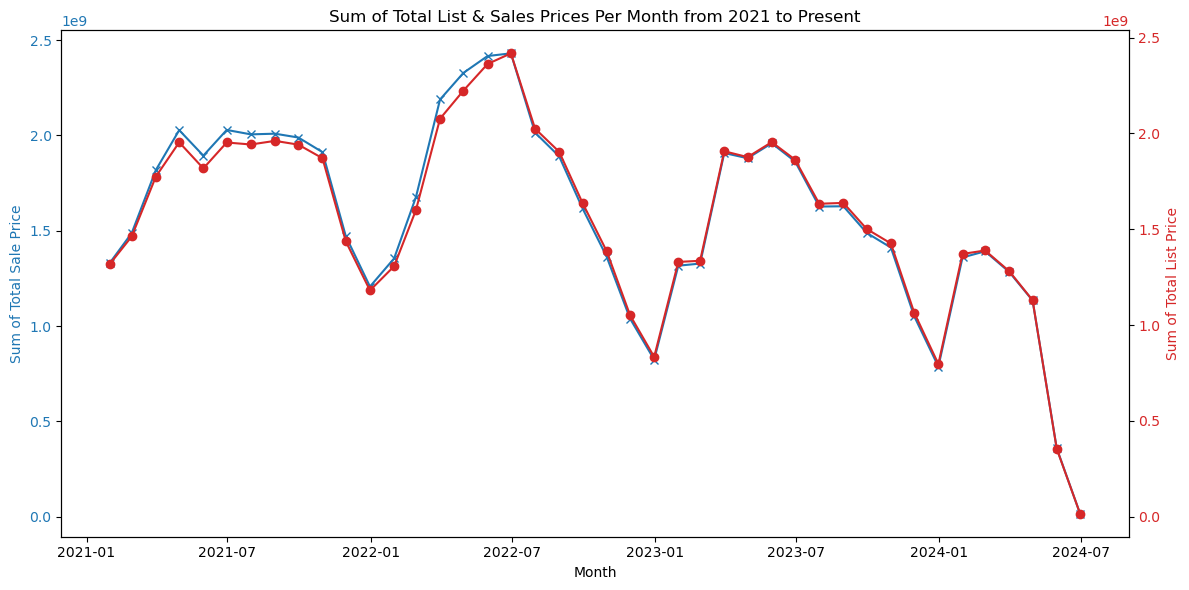

In [22]:
#setting the fig size. had to play around a bit to find a good fit.
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot that displays the sum of total sales price by month.
color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Sum of Total Sale Price', color=color)
ax1.plot(monthly_data_sold.index, monthly_data_sold['Total Sale Price'], color=color, marker='x')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Sum of Total List & Sales Prices Per Month from 2021 to Present')



# twin axes for the sum of the list prices
# telling the program that the axes will be plotted on the same graph. 
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Sum of Total List Price', color=color)
ax2.plot(monthly_data_list.index, monthly_data_list['Total List Price'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)


#tightening the layout
fig.tight_layout()  
print(monthly_data_list)
plt.show()

Text(0.5, 1.0, 'Total Properties Listed by Month')

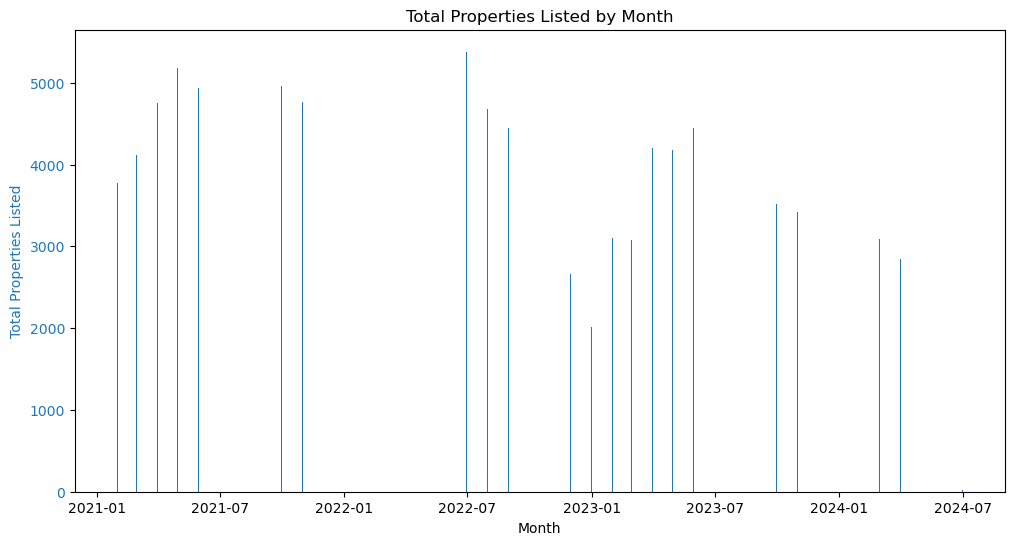

In [23]:
# bar chart that displays total properties listed per month.
fig, sales_volume = plt.subplots(figsize=(12, 6))
color = 'tab:blue'
sales_volume.set_xlabel('Month')
sales_volume.set_ylabel('Total Properties Listed', color=color)
sales_volume.bar(monthly_data_list.index, monthly_data_list['Total Properties Listed'], color=color)
sales_volume.tick_params(axis='y', labelcolor=color)
sales_volume.set_title('Total Properties Listed by Month')


### Fixing winston-salem vs winston salem rows:

In [24]:
combined_df = combined_df.replace(["Winston Salem"], "Winston-Salem")

In [25]:
combined_df.loc[combined_df["City"] == "Winston-Salem"]

,MLS #,Class,Property Type,Address,City,Zip,Neighborhood,Subdivision,Bedrooms,Total Baths,...,Year Built,List Date,Closing Date,Days On Market,List Price,Sold Price,Acres min,Acres max,Season Listed,Season Sold
850,10027582,RESIDENTIAL,Single Family Residence,597 Lakeside Valley Drive,Winston-Salem,27107,NaN,To Be Added,3.0,2,...,2002-01-01,2024-05-06,2024-05-30,2,190000.0,202000.0,0.00,0.25,Spring,Spring
1207,10014030,RESIDENTIAL,Single Family Residence,120 W Davidson Avenue,Winston-Salem,27127,NaN,To Be Added,3.0,2,...,2004-01-01,2024-02-22,2024-04-30,11,245000.0,230000.0,0.00,0.25,Winter,Spring
1285,LP721905,RESIDENTIAL,Single Family Residence,1600 Quillmark Road,Winston-Salem,27127,NaN,NaN,3.0,2,...,1992-01-01,2024-03-26,2024-05-15,17,230000.0,235000.0,0.26,0.50,Spring,Spring
2083,10019242,RESIDENTIAL,Single Family Residence,2501 Dier Lane,Winston-Salem,27107,NaN,Not in a Subdivision,2.0,2,...,1988-01-01,2024-03-26,2024-05-02,2,270000.0,272000.0,0.26,0.50,Spring,Spring
2102,10012411,RESIDENTIAL,Single Family Residence,5032 Wrangler Drive,Winston-Salem,27101,NaN,Winchester,3.0,2,...,1985-01-01,2024-02-19,2024-04-15,35,285000.0,273000.0,0.26,0.50,Winter,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155239,10011304,RESIDENTIAL,Single Family Residence,19 Garden Valley Drive,Winston-Salem,27107.0,NaN,To Be Added,4.0,3,...,2006-01-01,2024-02-12,2024-03-06,2,500000.0,510000.0,1.00,2.90,Winter,Spring
157631,119442,RESIDENTIAL,Single Family Residence,2205 Sunderland Road,Winston-Salem,27103,NaN,NaN,2.0,2,...,1973-01-01,2021-01-19,2021-01-19,1135,65000.0,65000.0,0.00,0.25,Winter,Winter
157844,114006,RESIDENTIAL,Single Family Residence,2313 Terra Stone Court,Winston-Salem,27103,NaN,NaN,2.0,2,...,1982-01-01,2020-12-28,2021-03-09,18,102000.0,101200.0,0.00,0.25,Winter,Spring
158287,116402,RESIDENTIAL,Single Family Residence,2745 Laguna Avenue,Winston-Salem,27103,NaN,NaN,3.0,2,...,1971-01-01,2021-02-12,2021-03-26,3,144900.0,143500.0,0.00,0.25,Winter,Spring


In [26]:
city_counts = combined_df['City'].value_counts()

#resetting index to check alphabetically
city_counts_df = city_counts.reset_index()
#making new column to show occurrences
city_counts_df.columns = ['City', 'Occurrences']

#sorting alphabetically
city_counts_df = city_counts_df.sort_values('City')


city_counts_df.to_csv('City_Occurrences.csv', index=False)

###### Winston-Salem looks to be the only duplicate city name.

#### Grouping by City, Zip, Sold Price:
#### Grouping by City, Zip, Days on market:

In [27]:
sold_price_grouped = combined_df[["City", "Zip", "Sold Price"]].sort_values(by="Sold Price", ascending=True)
DaysOnMarket_grouped = combined_df[["City", "Zip", "Days On Market"]].sort_values(by="Days On Market", ascending=True)

### Days on market grouped for all cities/zipcodes:
### Sold Price grouped for all cities/zipcodes:

In [28]:
display(DaysOnMarket_grouped, sold_price_grouped)

,City,Zip,Days On Market
0,Gibsonville,27249,0
63895,Durham,27713,0
63896,Wake Forest,27587,0
63897,Apex,27523,0
63898,Pittsboro,27312,0
...,...,...,...
20831,Willow Springs,27592,1285
160470,Graham,27253,1336
21211,Burlington,27215,1459
40230,Fayetteville,28311,2398


,City,Zip,Sold Price
157484,Fayetteville,28311,79.0
64359,Hope Mills,28348,221.0
54402,Warrenton,27589,345.0
0,Gibsonville,27249,367.0
138193,Southern Pines,28387,375.0
...,...,...,...
138192,Raleigh,27614,6150000.0
10656,Rolesville,27571,6395000.0
64358,Raleigh,27608,6400000.0
76284,Cary,27518,6498000.0


####  DOM = days on market
#### Sold Price = SP

In [29]:
raleigh_grouped_all = combined_df.loc[combined_df["City"] == "Raleigh"]
raleigh_grouped_SP = sold_price_grouped.loc[sold_price_grouped["City"] == "Raleigh"]
raleigh_grouped_DOM = DaysOnMarket_grouped.loc[DaysOnMarket_grouped["City"] == "Raleigh"]
raleigh_grouped_all

fayetteville_grouped_all = combined_df.loc[combined_df["City"] == "Fayetteville"]
fayetteville_grouped_SP = sold_price_grouped.loc[sold_price_grouped["City"] == "Fayetteville"]
fayetteville_grouped_DOM = DaysOnMarket_grouped.loc[DaysOnMarket_grouped["City"] == "Fayetteville"]
fayetteville_grouped_all

,MLS #,Class,Property Type,Address,City,Zip,Neighborhood,Subdivision,Bedrooms,Total Baths,...,Year Built,List Date,Closing Date,Days On Market,List Price,Sold Price,Acres min,Acres max,Season Listed,Season Sold
2,LP725056,RESIDENTIAL,Single Family Residence,872 Danish Drive,Fayetteville,28303,NaN,NaN,3.0,2,...,1989-01-01,2024-05-09,2024-06-13,0,210000.0,21000.0,NaN,NaN,Spring,Summer
3,10016080,RESIDENTIAL,Single Family Residence,2317 Slater Avenue,Fayetteville,28301,NaN,Not in a Subdivision,2.0,1,...,1947-01-01,2024-03-08,2024-04-01,3,65000.0,40000.0,0.00,0.25,Spring,Spring
14,10021849,RESIDENTIAL,Single Family Residence,2234 Pinpoint Road,Fayetteville,28312,NaN,Not in a Subdivision,3.0,1,...,1952-01-01,2024-04-09,2024-05-23,10,52000.0,52000.0,0.26,0.50,Spring,Spring
47,LP718663,RESIDENTIAL,Single Family Residence,200 Jasper Street,Fayetteville,28301,NaN,NaN,2.0,1,...,1955-01-01,2024-01-18,2024-04-01,55,80000.0,73000.0,NaN,NaN,Winter,Spring
48,LP723434,RESIDENTIAL,Single Family Residence,2307 Lake Avenue,Fayetteville,28301,NaN,NaN,3.0,2,...,1968-01-01,2024-05-07,2024-05-22,2,65000.0,74000.0,NaN,NaN,Spring,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167200,LP641585,RESIDENTIAL,Single Family Residence,6752 Surrey Road,Fayetteville,28306,NaN,Gates Four,5.0,4,...,2002-01-01,2020-08-31,2021-03-01,143,525000.0,495000.0,NaN,NaN,Summer,Spring
167390,LP647106,RESIDENTIAL,Single Family Residence,517 Swan Island Court,Fayetteville,28311,NaN,Kings Grant,4.0,4,...,2007-01-01,2020-12-05,2021-01-14,6,540000.0,520000.0,0.26,0.50,Winter,Winter
167404,LP641411,RESIDENTIAL,Single Family Residence,2836 Skye Drive,Fayetteville,28303,NaN,NaN,5.0,5,...,1971-01-01,2020-09-14,2021-02-11,116,550000.0,520000.0,NaN,NaN,Fall,Winter
167873,LP645267,RESIDENTIAL,Single Family Residence,6317 Touchstone Drive,Fayetteville,28311,NaN,Greystone Farms,4.0,5,...,2007-01-01,2020-10-23,2021-02-12,71,625000.0,595000.0,0.51,0.75,Fall,Winter


### Raleigh Sold price:
### Raleigh Days on market:

In [30]:
display(raleigh_grouped_SP, raleigh_grouped_DOM)

,City,Zip,Sold Price
54403,Raleigh,27607,2200.0
157561,Raleigh,27603-2925,46000.0
64425,Raleigh,27603,56000.0
64424,Raleigh,27603,56000.0
64423,Raleigh,27603,56000.0
...,...,...,...
10654,Raleigh,27614,5121787.0
64357,Raleigh,27609,5478186.0
103430,Raleigh,27614,5833358.0
138192,Raleigh,27614,6150000.0


,City,Zip,Days On Market
63928,Raleigh,27603,0
146982,Raleigh,27616,0
146964,Raleigh,27603,0
146873,Raleigh,27603,0
64035,Raleigh,27608,0
...,...,...,...
53970,Raleigh,27609-6960,741
168792,Raleigh,27614,785
76274,Raleigh,27609-7618,931
54399,Raleigh,27609-7636,1003


In [31]:
display(fayetteville_grouped_SP, raleigh_grouped_DOM)

,City,Zip,Sold Price
157484,Fayetteville,28311,79.0
64360,Fayetteville,28312,2000.0
54404,Fayetteville,28303,8500.0
64361,Fayetteville,28312,10000.0
147694,Fayetteville,28306.0,12000.0
...,...,...,...
40036,Fayetteville,28312,1200000.0
40042,Fayetteville,28312,1200000.0
25355,Fayetteville,28312,1231500.0
54262,Fayetteville,28305,1250000.0


,City,Zip,Days On Market
63928,Raleigh,27603,0
146982,Raleigh,27616,0
146964,Raleigh,27603,0
146873,Raleigh,27603,0
64035,Raleigh,27608,0
...,...,...,...
53970,Raleigh,27609-6960,741
168792,Raleigh,27614,785
76274,Raleigh,27609-7618,931
54399,Raleigh,27609-7636,1003


### Creating filtered DataFrames for Raleigh & Fayetteville; removing unnecessary columns:

In [32]:
raleigh_grouped_3_2 = raleigh_grouped_all.loc[
    (raleigh_grouped_all["Bedrooms"] == 3.0) &
    (raleigh_grouped_all["Total Baths"] == 2.0)
]
raleigh_grouped_3_2 = raleigh_grouped_3_2[[
    "MLS #", "Property Type", "City", "Bedrooms", 
    "Total Baths", "Total Living Area SqFt",
    "Year Built", "List Date", "Closing Date",
    "Days On Market", "List Price", "Sold Price", "Acres min", "Acres max",
    "Season Listed", "Season Sold"
    ]]

to_drop = raleigh_grouped_3_2[raleigh_grouped_3_2["Property Type"] == "Duplex"].index
raleigh_grouped_3_2 = raleigh_grouped_3_2.drop(to_drop)
raleigh_grouped_3_2


single_family_residence_3_2 = raleigh_grouped_3_2.loc[raleigh_grouped_3_2['Property Type'] == 'Single Family Residence']
single_family_residence_3_2

##################################################################

fayetteville_grouped_3_2 = fayetteville_grouped_all.loc[
    (fayetteville_grouped_all["Bedrooms"] == 3.0) &
    (fayetteville_grouped_all["Total Baths"] == 2.0)
]
fayetteville_grouped_3_2 = fayetteville_grouped_3_2[[
    "MLS #", "Property Type", "City", "Bedrooms", 
    "Total Baths", "Total Living Area SqFt",
    "Year Built", "List Date", "Closing Date",
    "Days On Market", "List Price", "Sold Price", "Acres min", "Acres max",
    "Season Listed", "Season Sold"
    ]]

to_drop = fayetteville_grouped_3_2[fayetteville_grouped_3_2["Property Type"] == "Duplex"].index
fayetteville_grouped_3_2 = fayetteville_grouped_3_2.drop(to_drop)
fayetteville_grouped_3_2


single_family_residence_3_2_fayetteville = fayetteville_grouped_3_2.loc[fayetteville_grouped_3_2['Property Type'] == 'Single Family Residence']
single_family_residence_3_2_fayetteville


,MLS #,Property Type,City,Bedrooms,Total Baths,Total Living Area SqFt,Year Built,List Date,Closing Date,Days On Market,List Price,Sold Price,Acres min,Acres max,Season Listed,Season Sold
2,LP725056,Single Family Residence,Fayetteville,3.0,2,1230.0,1989-01-01,2024-05-09,2024-06-13,0,210000.0,21000.0,NaN,NaN,Spring,Summer
48,LP723434,Single Family Residence,Fayetteville,3.0,2,0.0,1968-01-01,2024-05-07,2024-05-22,2,65000.0,74000.0,NaN,NaN,Spring,Spring
91,LP718376,Single Family Residence,Fayetteville,3.0,2,980.0,1994-01-01,2024-01-16,2024-04-03,15,95000.0,90000.0,0.26,0.50,Winter,Spring
97,LP722796,Single Family Residence,Fayetteville,3.0,2,0.0,1958-01-01,2024-04-12,2024-05-15,17,132500.0,91000.0,0.26,0.50,Spring,Spring
138,LP725493,Single Family Residence,Fayetteville,3.0,2,1596.0,1972-01-01,2024-05-13,2024-06-07,1,95000.0,110000.0,NaN,NaN,Spring,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160504,LP629934,Single Family Residence,Fayetteville,3.0,2,0.0,1951-01-01,2020-04-04,2021-01-04,224,229000.0,229000.0,NaN,NaN,Spring,Winter
160982,LP647535,Single Family Residence,Fayetteville,3.0,2,0.0,2006-01-01,2020-12-15,2021-03-05,22,235000.0,240000.0,NaN,NaN,Winter,Spring
161008,2362580,Single Family Residence,Fayetteville,3.0,2,2071.0,2004-01-01,2021-01-19,2021-03-08,7,235000.0,240000.0,0.51,0.75,Winter,Spring
161275,LP650367,Single Family Residence,Fayetteville,3.0,2,0.0,2021-01-01,2021-02-19,2021-02-20,0,246900.0,246900.0,0.26,0.50,Winter,Winter


In [33]:
raleigh_grouped_3_2["Property Type"].value_counts()

Property Type
Single Family Residence    3121
Townhouse                   185
Condo                       164
Manufactured                 41
Ranch                         8
Name: count, dtype: int64

In [34]:
fayetteville_grouped_3_2["Property Type"].value_counts()

Property Type
Single Family Residence    3435
Condo                       201
Manufactured                 73
Townhouse                    20
Other                        12
Ranch                         2
Name: count, dtype: int64

### Visualization of days on market per season listed

##### "DOM" = Days on market
##### "SZN" = Season

In [35]:
def grouping_by_season(original_df, column_name):

    #creating new dataframe that is grouped by season listed and the average days on market for each season listed.
    df_to_order = original_df.groupby('Season Listed')[column_name].mean().reset_index()

    #creating list to use as template for displaying seasons in order (Spring-Summer-Fall-Winter)
    season_order = ['Spring', 'Summer', 'Fall', 'Winter']

    #converting season listed column to categorical type and then setting the order based on season_order list.
    df_to_order['Season Listed'] = pd.Categorical(df_to_order['Season Listed'], categories=season_order, ordered=True)

    #sorting the values now that they are categorized in the correct order
    df_to_order = df_to_order.sort_values('Season Listed')
    return(df_to_order)

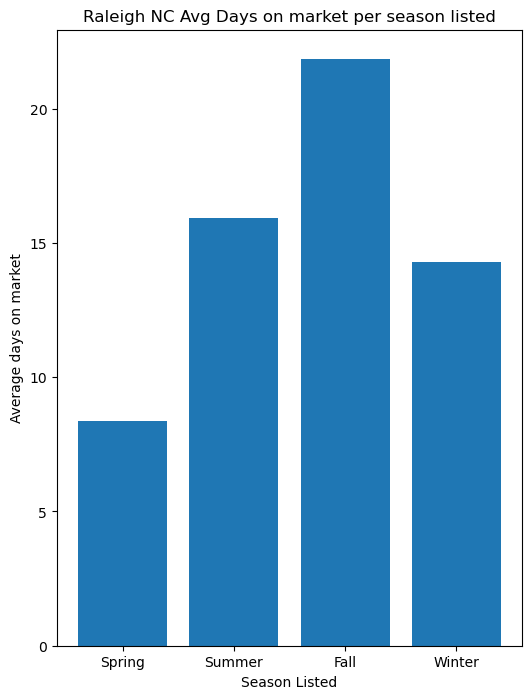

In [36]:
DOM_var = "Days On Market"
raleigh_DOM_SZN_grouped = grouping_by_season(original_df=raleigh_grouped_3_2, column_name=DOM_var)


plt.figure(figsize=(6, 8))
plt.xlabel("Season Listed")
plt.ylabel("Average days on market")
plt.bar(raleigh_DOM_SZN_grouped['Season Listed'], raleigh_DOM_SZN_grouped['Days On Market'])
plt.title("Raleigh NC Avg Days on market per season listed")
plt.show()


##### The chart above shows that the average days on market for Raleigh NC are highest in the fall, and lowest in the spring.

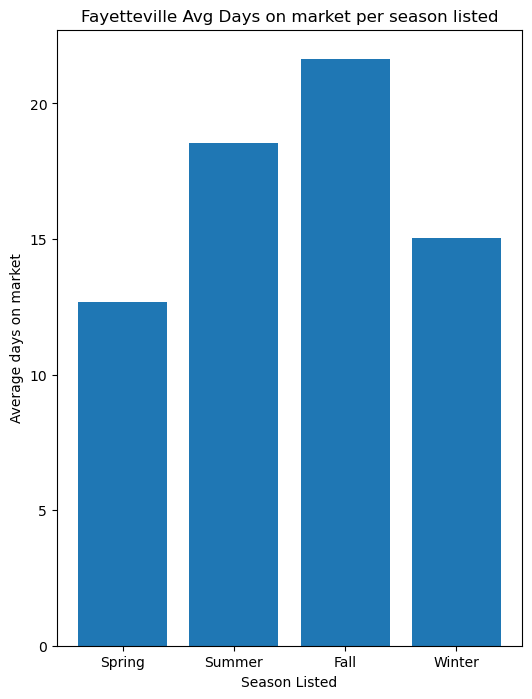

In [37]:
fayetteville_DOM_SZN_grouped = grouping_by_season(original_df=combined_df, column_name=DOM_var)

plt.figure(figsize=(6, 8))
plt.xlabel("Season Listed")
plt.ylabel("Average days on market")
plt.bar(fayetteville_DOM_SZN_grouped['Season Listed'], fayetteville_DOM_SZN_grouped['Days On Market'])
plt.title("Fayetteville Avg Days on market per season listed")
plt.show()

##### The chart above shows a similar trend to that of Raleigh NC, with the highest average days on market for Fayetteville NC being in the fall, and the lowest in the spring.

### Visualization of Delta between List Price and sale price based on seasonality:

##### Creating new column called "Price Delta":

In [38]:
raleigh_grouped_3_2["Price Delta"] = raleigh_grouped_3_2["Sold Price"] - raleigh_grouped_3_2["List Price"]
fayetteville_grouped_3_2["Price Delta"] = fayetteville_grouped_3_2["Sold Price"] - fayetteville_grouped_3_2["List Price"]
#raleigh_grouped_3_2

#### Price delta per season bar chart:

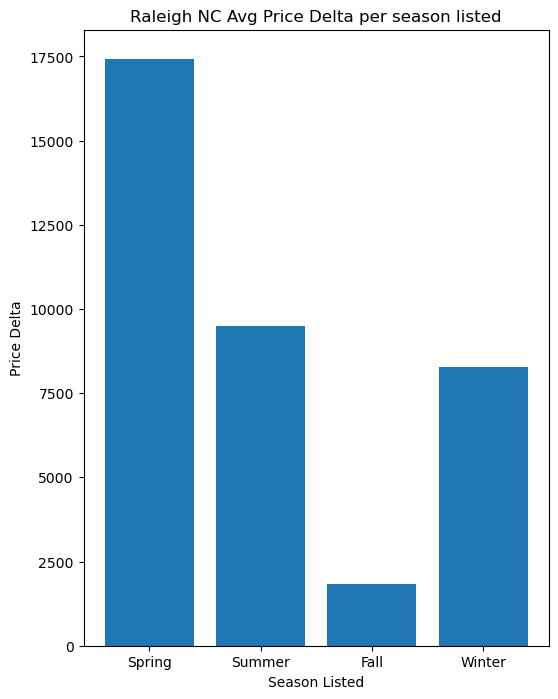

In [39]:
delta_var = "Price Delta"
raleigh_delta_SZN_grouped = grouping_by_season(original_df=raleigh_grouped_3_2, column_name=delta_var)
plt.figure(figsize=(6, 8))
plt.xlabel("Season Listed")
plt.ylabel("Price Delta")
plt.bar(raleigh_delta_SZN_grouped['Season Listed'], raleigh_delta_SZN_grouped["Price Delta"])
plt.title("Raleigh NC Avg Price Delta per season listed")
plt.show()

##### The chart above shows that the highest price delta for Raleigh NC is in the spring, followed by winter and summer, with the fall showing the lowest price delta.

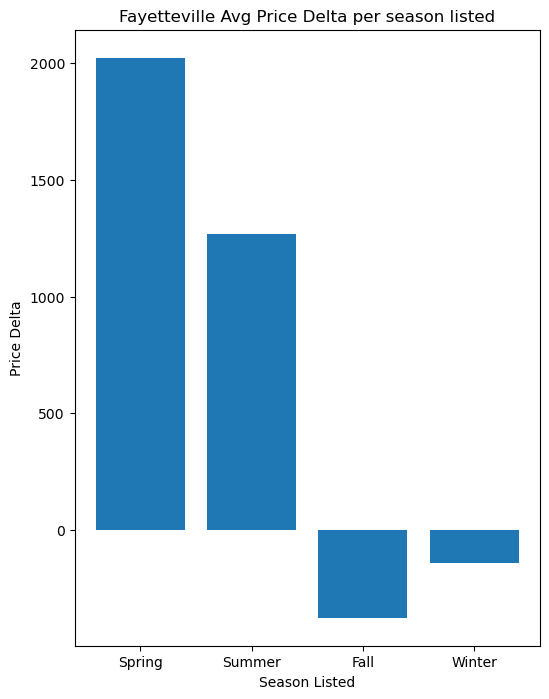

In [40]:
fayetteville_DOM_SZN_grouped = grouping_by_season(original_df=fayetteville_grouped_3_2, column_name=delta_var)

plt.figure(figsize=(6, 8))
plt.xlabel("Season Listed")
plt.ylabel("Price Delta")
plt.bar(fayetteville_DOM_SZN_grouped['Season Listed'], fayetteville_DOM_SZN_grouped["Price Delta"])
plt.title("Fayetteville Avg Price Delta per season listed")
plt.show()

##### The chart above shows that similar to Raleigh, Fayetteville also has the highest price delta in the spring. However, the values for summer, fall, and winter are significantly lower compared to Raleigh.

# Analysis of Mortage rates and its effect on real estate sales 

#### Read the mortgage rate CSV file 

In [41]:
# read all the mortage data from the CSV  File
mortageweekly_df = pd.read_excel("../Real-Estate-Analysis-Project/Data/weekly_mortgage_rates.xlsx",
                                 index_col="Week",
                                 parse_dates=True
                                 )
mortageweekly_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../Real-Estate-Analysis-Project/Data/weekly_mortgage_rates.xlsx'

#### Clean up mortgage dataframe

In [ ]:
# Get the morrtgage data from 2021 ro 2014 
mortageweekly_df_sliced = mortageweekly_df.loc['2021-01-01':'2024-05-30']

#drop unwanted columns
mortageweekly_df_sliced.drop(columns=['30 years points','15 years FRM','15 years points','ARM','ARM points','margin','spread'],inplace=True)

mortageweekly_df_sliced.plot(figsize=[10,5])

In [ ]:
# add a column of week and year
mortageweekly_df_sliced["week-year"]  = mortageweekly_df_sliced.index.year.astype(str) + mortageweekly_df_sliced.index.isocalendar().week.astype(str)
mortageweekly_df_sliced.head()

#### Get single family homes real estate data 

In [ ]:
#single_family Raleigh
single_family_residence_3_2["week-year"]  = single_family_residence_3_2['List Date'].dt.year.astype(str) + single_family_residence_3_2['List Date'].dt.isocalendar().week.astype(str)
single_family_residence_3_2["Price Delta"] = single_family_residence_3_2["Sold Price"] - single_family_residence_3_2["List Price"]
single_family_residence_3_2.head() #162138 

#single_family Fayetteville
single_family_residence_3_2_fayetteville["week-year"]  = single_family_residence_3_2_fayetteville['List Date'].dt.year.astype(str) + single_family_residence_3_2_fayetteville['List Date'].dt.isocalendar().week.astype(str)
single_family_residence_3_2_fayetteville["Price Delta"] = single_family_residence_3_2_fayetteville["Sold Price"] - single_family_residence_3_2_fayetteville["List Price"]
single_family_residence_3_2_fayetteville.head() #162138 

#### Merge morgage data and single family real esate data frame on week-year of list date 

In [ ]:
#merge mortageweekly_df_sliced and single_family_residence_3_2 on week year column
realeastate_df  = pd.merge(mortageweekly_df_sliced,single_family_residence_3_2,on="week-year",how="inner")
realeastate_df_fayetteville  = pd.merge(mortageweekly_df_sliced,single_family_residence_3_2_fayetteville,on="week-year",how="inner")


In [ ]:
#Group by month and find average month data 
realeastate_monthly_df = realeastate_df.resample('M', on='List Date').agg({'Days On Market': ['mean'],"30 Years FRM":['mean'], "Price Delta":['mean']})

realeastate_monthly_df.columns = ['Avg Days on Market', 'Avg Intereset Rate','Avg Price Delta']

realeastate_monthly_df.head()

In [ ]:
#Group by month and find average month data 
realeastate_monthly_df_fayetteville = realeastate_df_fayetteville.resample('M', on='List Date').agg({'Days On Market': ['mean'],"30 Years FRM":['mean'], "Price Delta":['mean']})

realeastate_monthly_df_fayetteville.columns = ['Avg Days on Market', 'Avg Intereset Rate','Avg Price Delta']

realeastate_monthly_df_fayetteville.head()

### Visualize correlation between mortgage rate and the property days on market 

In [ ]:

#setting the fig size. 
fig, ax1 = plt.subplots(figsize=(12, 6))

# bar chart that displays average days on market for property in a month.
color = 'tab:blue'
ax1.set_xlabel('List Date')
ax1.set_ylabel('Days On Market', color=color)
ax1.plot(realeastate_monthly_df.index, realeastate_monthly_df['Avg Days on Market'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Raleigh: Days On market and mortgage rate correlation')

# twin axes for the average mortage rate in a month
# telling the program that the axes will be plotted on the same graph. 
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Avg Intereset Rate', color=color)
ax2.plot(realeastate_monthly_df.index, realeastate_monthly_df['Avg Intereset Rate'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)


#tightening the layout
fig.tight_layout()  
plt.show()


In [ ]:

#setting the fig size. 
fig, ax1 = plt.subplots(figsize=(12, 6))

# bar chart that displays average days on market for property in a month.
color = 'tab:blue'
ax1.set_xlabel('List Date')
ax1.set_ylabel('Days On Market', color=color)
ax1.plot(realeastate_monthly_df_fayetteville.index, realeastate_monthly_df_fayetteville['Avg Days on Market'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Fayetteville: Days On market and mortgage rate correlation')

# twin axes for the average mortage rate in a month
# telling the program that the axes will be plotted on the same graph. 
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Avg Intereset Rate', color=color)
ax2.plot(realeastate_monthly_df_fayetteville.index, realeastate_monthly_df_fayetteville['Avg Intereset Rate'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)


#tightening the layout
fig.tight_layout()  
plt.show()

##### Above graph indicate that the homes days on market has increased when the mortgage rate increased 

### Visualize correlation between mortgage rate and delta between list price and sales price 

In [ ]:


#setting the fig size. had to play around a bit to find a good fit.
fig, ax1 = plt.subplots(figsize=(12, 6))

# bar chart that displays average delta between list price and sold price 
color = 'tab:blue'
ax1.set_xlabel('List Date')
ax1.set_ylabel('Avg Price Delta', color=color)
ax1.plot(realeastate_monthly_df.index, realeastate_monthly_df['Avg Price Delta'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Raleigh: List Price - Sold price delta and mortgage rate correlation')

# getting the array of values of y-axis
ticks = ax1.get_yticks()
# formatted the values into strings beginning with dollar sign
new_labels = [f'${amt:,.0f}' for amt in ticks] 
# Set the new labels
ax1.set_yticklabels(new_labels)

# twin axes for the average mortage rate in a month
# telling the program that the axes will be plotted on the same graph. 
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Avg Intereset Rate', color=color)
ax2.plot(realeastate_monthly_df.index, realeastate_monthly_df['Avg Intereset Rate'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)



#tightening the layout
fig.tight_layout()  
plt.show()



In [ ]:
#setting the fig size. had to play around a bit to find a good fit.
fig, ax1 = plt.subplots(figsize=(12, 6))

# bar chart that displays average delta between list price and sold price 
color = 'tab:blue'
ax1.set_xlabel('List Date')
ax1.set_ylabel('Avg Price Delta', color=color)
ax1.plot(realeastate_monthly_df_fayetteville.index, realeastate_monthly_df_fayetteville['Avg Price Delta'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Fayetteville: List Price - Sold price delta and mortgage rate correlation')

# getting the array of values of y-axis
ticks = ax1.get_yticks()
# formatted the values into strings beginning with dollar sign
new_labels = [f'${amt:,.0f}' for amt in ticks] 
# Set the new labels
ax1.set_yticklabels(new_labels)
                    
# twin axes for the average mortage rate in a month
# telling the program that the axes will be plotted on the same graph. 
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Avg Intereset Rate', color=color)
ax2.plot(realeastate_monthly_df_fayetteville.index, realeastate_monthly_df_fayetteville['Avg Intereset Rate'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)


#tightening the layout
fig.tight_layout()  
plt.show()

##### There is no correlation between the mortgage rate and delta between list price and sold price 